# STACKING  | Machine Learning II

---
## Import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#from sklearn import metrics
#from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.inspection import permutation_importance

# stacking
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.linear_model  import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

#from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# others
from mltools import classification_tools as CT
from mltools import model_tools as MT

---
#  1. Regression problem

Set the synthetic problem

In [2]:
# Synthetic problem
np.random.RandomState(9999)

n = 1000
X = np.random.uniform(0, 10.0, size=n)

y_true_left = X * np.sin(X)
y_true_right = X * np.sin(2*X)

# add a step
y_true = y_true_left
y_true[X>6] = 15 - y_true_right[X>6]

noise =  0.5 * (1 + X**0.8) * np.random.normal(scale=1, loc=0, size=n)
y = y_true + noise

#sort the inputs for easy plotting
idx = np.argsort(X)
X = X[idx]
y_true = y_true[idx]
y = y[idx]

Split the dataset in TR and TS and plot the problem

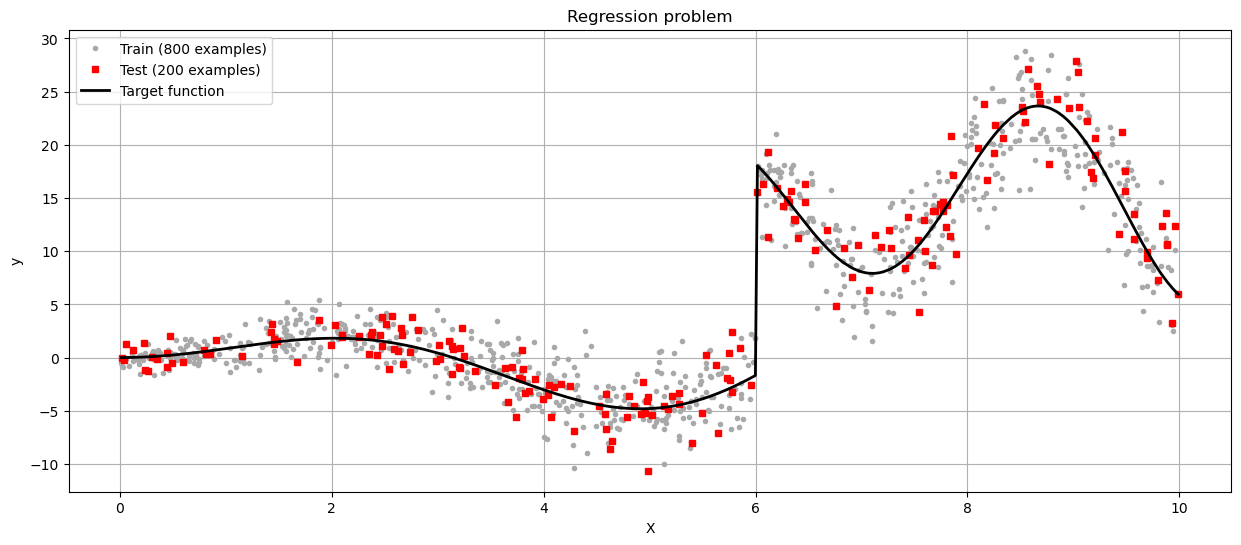

In [3]:
## 1.3 Split the dataset in TR and TS
 
# # Define input and output matrices
INPUTS = ['X']
OUTPUT = 'Y'

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0) #seed for replication

#sort the inputs for easy plotting
idx = np.argsort(X_train)
X_train = X_train[idx]
y_train = y_train[idx]

idx = np.argsort(X_test)
X_test = X_test[idx]
y_test = y_test[idx]

# 2D-array versions to feed models
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

# Plot data
plt.figure(figsize=(15, 6))
plt.plot(X_train,y_train,'.', color='darkgray', label=f'Train ({len(X_train)} examples)')
plt.plot(X_test,y_test,'sr', markersize = 4, label=f'Test ({len(X_test)} examples)')
plt.plot(X, y_true, '-', color = 'black', linewidth=2, label='Target function')
plt.title('Regression problem')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.show()

## 1.1 Polynomial model

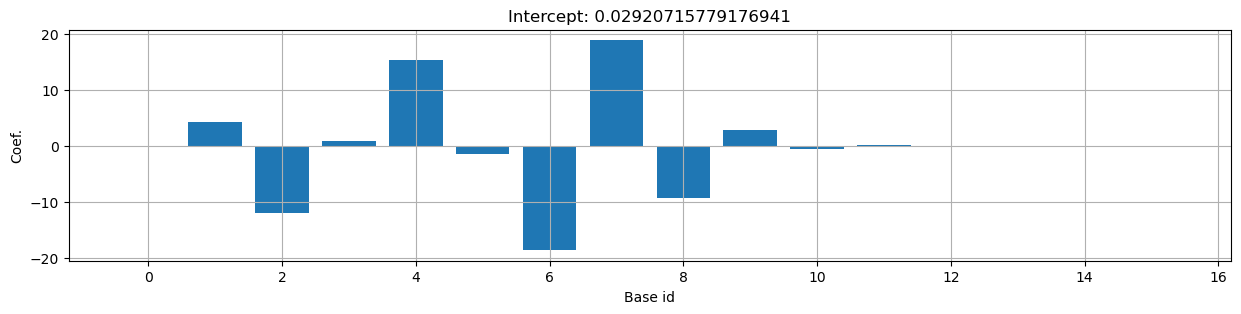

In [4]:
# First, create the basis functions using SplineTransformer
degree = 15 # order of the basis polynomials

plf = PolynomialFeatures(degree=degree).fit(X_train)
X_train_plf = plf.transform(X_train)

# fit the B-spline using ridge regression
ridge_plf = Ridge(alpha=0.1)
ridge_plf.fit(X_train_plf, y_train)

# show coefs
plt.figure(figsize=(15, 3))
plt.bar(range(degree+1), ridge_plf.coef_)
plt.title(f'Intercept: {ridge_plf.intercept_}')
plt.xlabel('Base id')
plt.ylabel('Coef.')
plt.grid()
plt.show()

Compute errors of the polynomial

In [5]:
# estimations using the spline
y_train_poly = ridge_plf.predict(X_train_plf)

X_test_plf = plf.transform(X_test)
y_test_poly = ridge_plf.predict(X_test_plf)

# errors
mse_tr_poly = mean_squared_error(y_train_poly, y_train)
mse_ts_poly = mean_squared_error(y_test_poly, y_test)

mae_tr_poly = mean_absolute_error(y_train_poly, y_train)
mae_ts_poly = mean_absolute_error(y_test_poly, y_test)

print(f'MSE(TR, poly) = {mse_tr_poly}')
print(f'MSE(TS, poly) = {mse_ts_poly}')
print(f'MAE(TR, poly) = {mae_tr_poly}')
print(f'MAE(TS, poly) = {mae_ts_poly}')

MSE(TR, poly) = 10.20446645169947
MSE(TS, poly) = 8.86952307537458
MAE(TR, poly) = 2.308607899529942
MAE(TS, poly) = 2.142133047266614


Plot Polynomial results

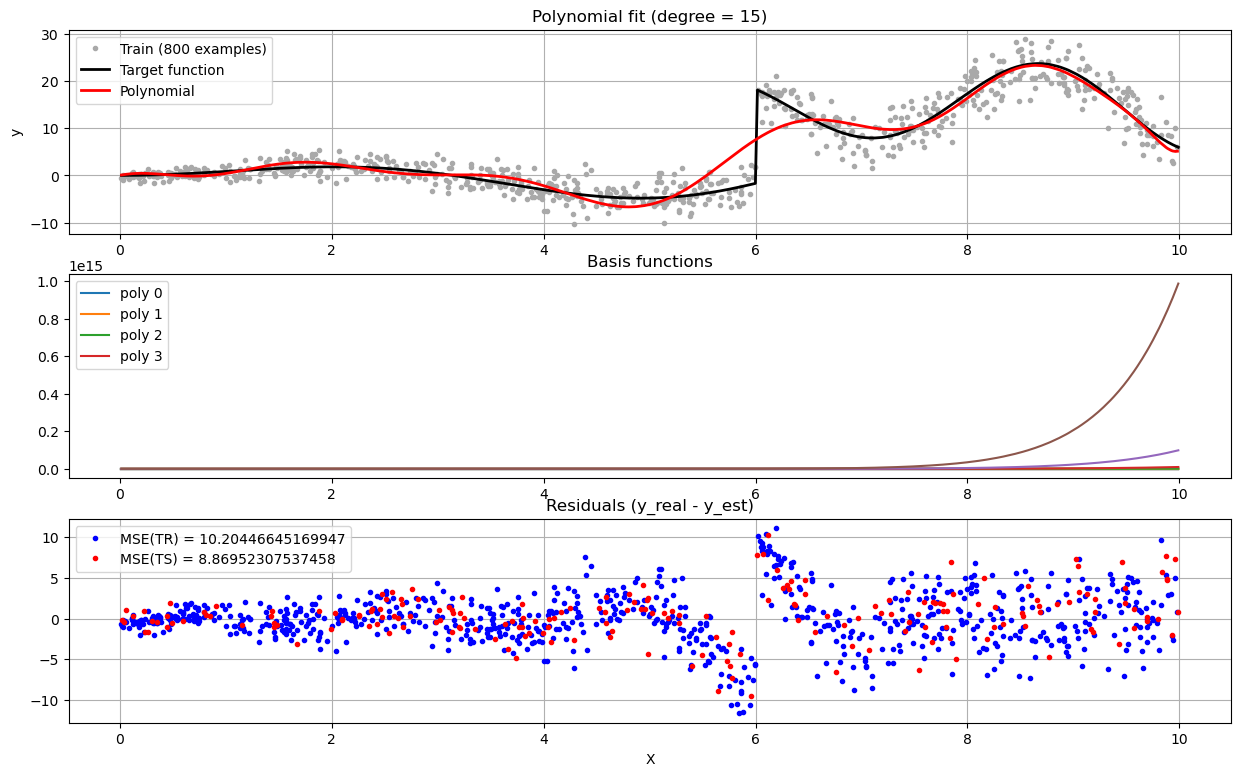

In [6]:
# Plot data
plt.figure(figsize=(15, 9))
ax1 = plt.subplot(3,1,1)
plt.plot(X_train,y_train,'.', color='darkgray', label=f'Train ({len(X_train)} examples)')
plt.plot(X, y_true, '-', color = 'black', linewidth=2, label='Target function')
plt.plot(X_train, y_train_poly, '-', color = 'red', linewidth=2, label='Polynomial')
plt.grid()
plt.legend()
plt.title(f'Polynomial fit (degree = {degree})')
plt.ylabel('y')

# plot basis
plt.subplot(3,1,2, sharex = ax1)
plt.plot(X, plf.transform(X[:, np.newaxis]))
plt.legend([f"poly {n}" for n in range(4)])
plt.title('Basis functions')

# plot residuals
plt.subplot(3,1,3, sharex = ax1)
plt.plot(X_train, y_train - y_train_poly, '.', color = 'blue', label=f'MSE(TR) = {mse_tr_poly}')
plt.plot(X_test, y_test- y_test_poly, '.', color = 'red', label=f'MSE(TS) = {mse_ts_poly}')
plt.title(f'Residuals (y_real - y_est)')
plt.legend()
plt.grid()
plt.xlabel('X')
plt.show()

## 1.2 B-spline model

SplineTransformer generates B-spline basis functions. A basis function of a B-spline is a piece-wise polynomial function that is non-zero only between consecutive knots. Given number of knots, this results in matrix of n_samples rows and n_knots + degree - 1 columns:

[[basis_1(x_0), basis_2(x_0), ...],

 [basis_1(x_1), basis_2(x_1), ...],
 
 ...]

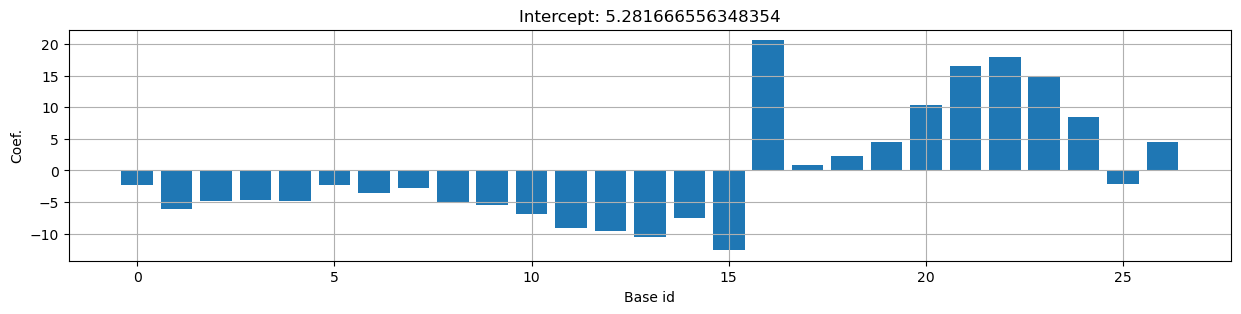

In [7]:
# First, create the basis functions using SplineTransformer
n_knots = 25 # number of "breaking points"
degree = 3 # order of the basis polynomials

splt = SplineTransformer(n_knots=n_knots, degree=degree).fit(X_train)
X_train_splt = splt.transform(X_train)

# fit the B-spline using ridge regression
ridge_splt = Ridge(alpha=0.1)
ridge_splt.fit(X_train_splt, y_train)

# show coefs
plt.figure(figsize=(15, 3))
plt.bar(range(n_knots+2), ridge_splt.coef_)
plt.title(f'Intercept: {ridge_splt.intercept_}')
plt.xlabel('Base id')
plt.ylabel('Coef.')
plt.grid()
plt.show()

Compute errors of B-spline

In [9]:
# estimations using the spline
y_train_spline = ridge_splt.predict(X_train_splt)

X_test_splt = splt.transform(X_test)
y_test_spline = ridge_splt.predict(X_test_splt)

# errors
mse_tr_spline = mean_squared_error(y_train_spline, y_train)
mse_ts_spline = mean_squared_error(y_test_spline, y_test)

mae_tr_spline = mean_absolute_error(y_train_spline, y_train)
mae_ts_spline = mean_absolute_error(y_test_spline, y_test)

print(f'MSE(TR, spline) = {mse_tr_spline}')
print(f'MSE(TS, spline) = {mse_ts_spline}')
print(f'MAE(TR, spline) = {mae_tr_spline}')
print(f'MAE(TS, spline) = {mae_ts_spline}')

MSE(TR, spline) = 6.679719205848191
MSE(TS, spline) = 6.45183663533421
MAE(TR, spline) = 1.9258803801109468
MAE(TS, spline) = 1.8663084688192981


Plot B-spline results

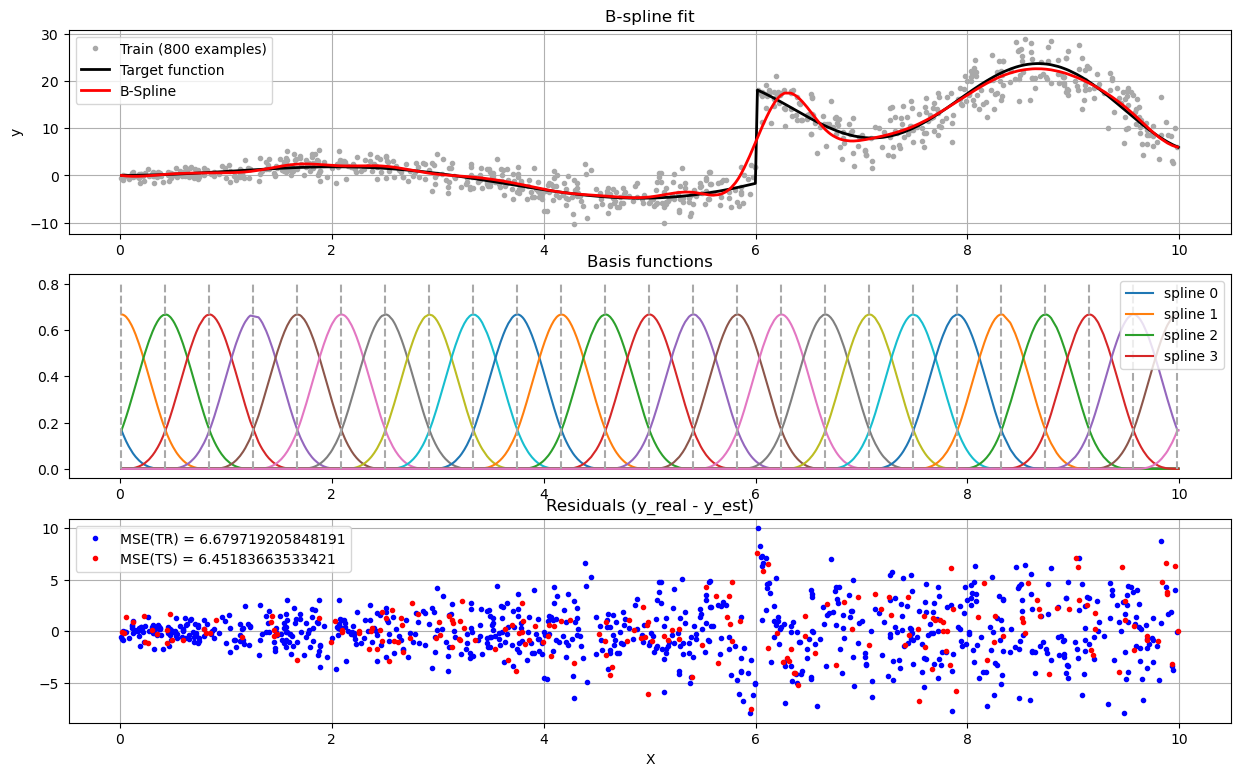

In [10]:
# Plot data
plt.figure(figsize=(15, 9))
ax1 = plt.subplot(3,1,1)
plt.plot(X_train,y_train,'.', color='darkgray', label=f'Train ({len(X_train)} examples)')
plt.plot(X, y_true, '-', color = 'black', linewidth=2, label='Target function')
plt.plot(X_train, y_train_spline, '-', color = 'red', linewidth=2, label='B-Spline')
plt.grid()
plt.legend()
plt.title('B-spline fit')
plt.ylabel('y')

# plot basis with the knots of the spline
plt.subplot(3,1,2, sharex = ax1)
plt.plot(X, splt.transform(X[:, np.newaxis]))
plt.legend([f"spline {n}" for n in range(4)])
plt.title('Basis functions')

knots = splt.bsplines_[0].t
plt.vlines(knots[degree:-degree], color = 'darkgray', ymin=0, ymax=0.8, linestyles="dashed")


# plot residuals
plt.subplot(3,1,3, sharex = ax1)
plt.plot(X_train, y_train - y_train_spline, '.', color = 'blue', label=f'MSE(TR) = {mse_tr_spline}')
plt.plot(X_test, y_test- y_test_spline, '.', color = 'red', label=f'MSE(TS) = {mse_ts_spline}')
plt.title(f'Residuals (y_real - y_est)')
plt.legend()
plt.grid()
plt.xlabel('X')
plt.show()

## 1.3 Simple regression tree

In [11]:
# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

pipe = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
single_reg_tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
                       
single_reg_tree_fit.fit(X_train.reshape(-1, 1), y_train) # Search in grid

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
6930 fits failed out of a total of 62370.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6930 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\pipeline.py", line 42

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeRegressor(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0...035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

Compute errors of regression tree

In [12]:
# estimations using the spline
y_train_regtree = single_reg_tree_fit.best_estimator_['DT'].predict(X_train)
y_test_regtree = single_reg_tree_fit.best_estimator_['DT'].predict(X_test)

# errors
mse_tr_regtree = mean_squared_error(y_train_regtree, y_train)
mse_ts_regtree = mean_squared_error(y_test_regtree, y_test)

mae_tr_regtree = mean_absolute_error(y_train_regtree, y_train)
mae_ts_regtree = mean_absolute_error(y_test_regtree, y_test)

print(f'MSE(TR, regtree) = {mse_tr_regtree}')
print(f'MSE(TS, regtree) = {mse_ts_regtree}')
print(f'MAE(TR, regtree) = {mae_tr_regtree}')
print(f'MAE(TS, regtree) = {mae_ts_regtree}')

MSE(TR, regtree) = 2.2320635430235374
MSE(TS, regtree) = 8.872174170170586
MAE(TR, regtree) = 1.087878308526424
MAE(TS, regtree) = 2.264540192551002


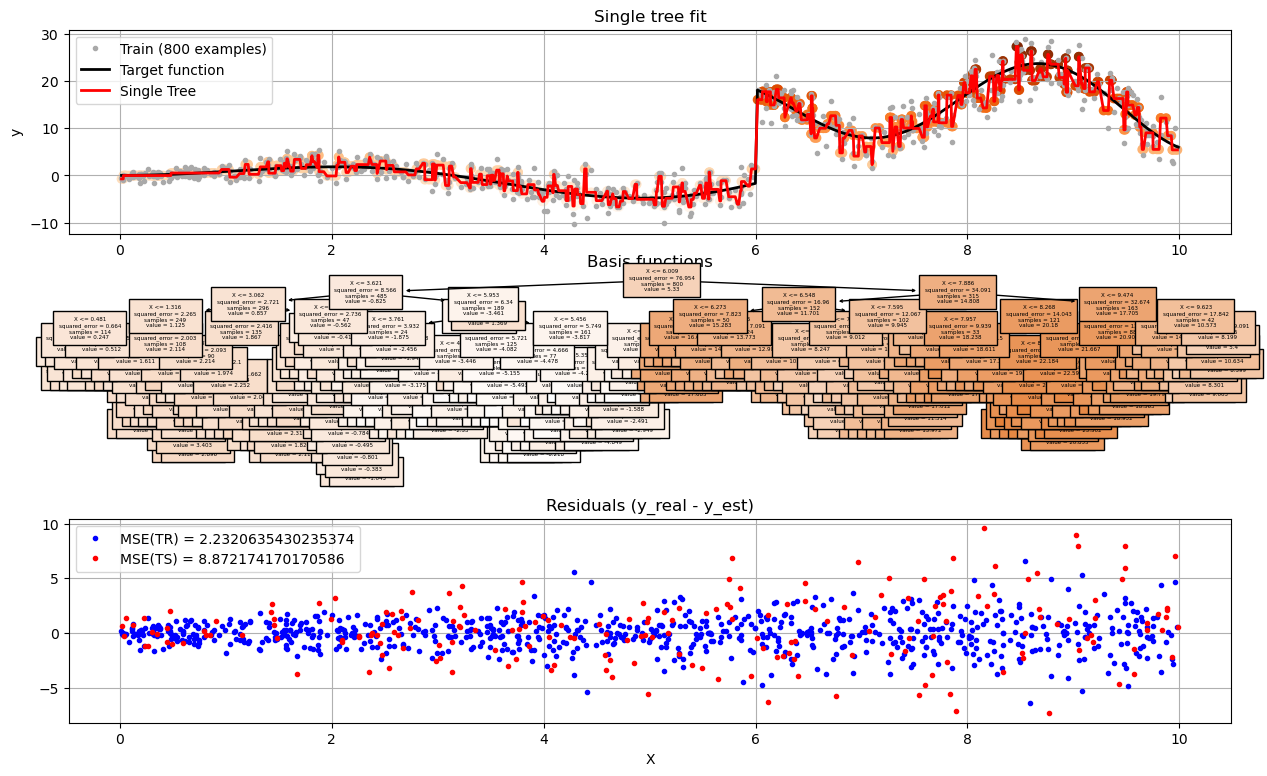

In [16]:
# Plot data
plt.figure(figsize=(15, 9))
ax1 = plt.subplot(3,1,1)
plt.plot(X_train,y_train,'.', color='darkgray', label=f'Train ({len(X_train)} examples)')
plt.plot(X, y_true, '-', color = 'black', linewidth=2, label='Target function')
plt.plot(X_train, y_train_regtree, '-', color = 'red', linewidth=2, label='Single Tree')
plt.scatter(X_train, y_train_regtree, c = y_train_regtree, cmap='Oranges')
plt.grid()
plt.legend()
plt.title('Single tree fit')
plt.ylabel('y')

# plot basis with the knots of the spline
plt.subplot(3,1,2, sharex = ax1)
plot_tree(single_reg_tree_fit.best_estimator_['DT'],
          feature_names= ['X'],
          fontsize=4, filled=True)
plt.title('Basis functions')

# plot residuals
plt.subplot(3,1,3, sharex = ax1)
plt.plot(X_train, y_train - y_train_regtree, '.', color = 'blue', label=f'MSE(TR) = {mse_tr_regtree}')
plt.plot(X_test, y_test- y_test_regtree, '.', color = 'red', label=f'MSE(TS) = {mse_ts_regtree}')
plt.title(f'Residuals (y_real - y_est)')
plt.legend()
plt.grid()
plt.xlabel('X')
plt.show()

## 1.4 Stacking

First define the estimators to be stacked

In [17]:
degree_poly = 15

n_knots_spline = 25 # number of "breaking points"
degree_basis_spline = 3 # order of the basis polynomials

# grid in min_impurity x min_samples_leaf x min_samples_split
param_tree = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

pipe_tree = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                         random_state=150))]) # For replication

nFolds_tree = 10

## set of estimators to be stacked
estimators = [
    ('poly', make_pipeline(
        PolynomialFeatures(degree_poly), 
        Ridge(alpha=1e-3))
    ),
    ('spline', make_pipeline(
        SplineTransformer(n_knots=n_knots, degree=degree),
        Ridge(alpha=1e-3))
    ),
    ('regtree', make_pipeline(
                GridSearchCV(estimator= pipe_tree,
                            param_grid=param_tree, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            cv=nFolds_tree)) # Number of Folds
    )
]

estimators

[('poly',
  Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=15)),
                  ('ridge', Ridge(alpha=0.001))])),
 ('spline',
  Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=25)),
                  ('ridge', Ridge(alpha=0.001))])),
 ('regtree',
  Pipeline(steps=[('gridsearchcv',
                   GridSearchCV(cv=10,
                                estimator=Pipeline(steps=[('DT',
                                                           DecisionTreeRegressor(random_state=150))]),
                                n_jobs=-1,
                                param_grid={'DT__min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
         0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
         0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
         0.027, 0.02...,
         0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
         0.045, 0.046, 0.047, 0.048, 0.049, 0.0

Fit the ensemble of stacked models

In [18]:
weights = [0.1, 0.2, 0.7]
stacked_reg = VotingRegressor(estimators = estimators, weights = weights)
stacked_reg = stacked_reg.fit(X_train, y_train)
stacked_reg.get_params()

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
6930 fits failed out of a total of 62370.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6930 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\pipeline.py", line 42

{'estimators': [('poly',
   Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=15)),
                   ('ridge', Ridge(alpha=0.001))])),
  ('spline',
   Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=25)),
                   ('ridge', Ridge(alpha=0.001))])),
  ('regtree',
   Pipeline(steps=[('gridsearchcv',
                    GridSearchCV(cv=10,
                                 estimator=Pipeline(steps=[('DT',
                                                            DecisionTreeRegressor(random_state=150))]),
                                 n_jobs=-1,
                                 param_grid={'DT__min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
          0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
          0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
          0.027, 0.02...,
          0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
          0.045,

In [19]:
# estimations using the stacked models
y_train_stack = stacked_reg.predict(X_train)
y_test_stack = stacked_reg.predict(X_test)

# errors
mse_tr_stack = mean_squared_error(y_train_stack, y_train)
mse_ts_stack = mean_squared_error(y_test_stack, y_test)

mae_tr_stack = mean_absolute_error(y_train_stack, y_train)
mae_ts_stack = mean_absolute_error(y_test_stack, y_test)

print(f'MSE(TR, stack) = {mse_tr_stack}')
print(f'MSE(TS, stack) = {mse_ts_stack}')
print(f'MAE(TR, stack) = {mae_tr_stack}')
print(f'MAE(TS, stack) = {mae_ts_stack}')

MSE(TR, stack) = 2.6748093795309806
MSE(TS, stack) = 7.2080189092860785
MAE(TR, stack) = 1.1992736376609445
MAE(TS, stack) = 2.0204072697690707


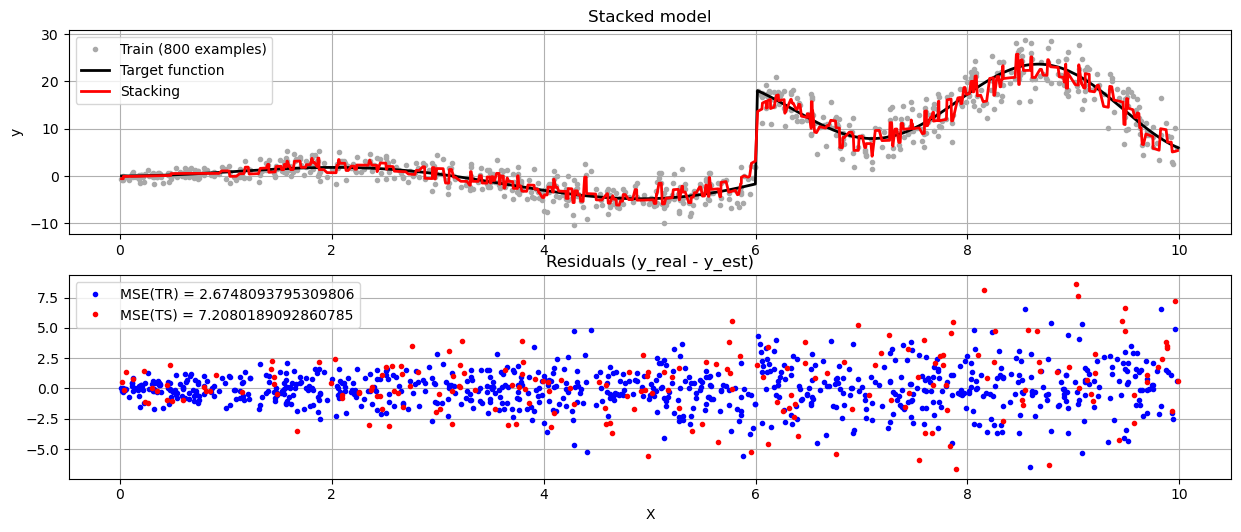

In [20]:
# Plot data
plt.figure(figsize=(15, 9))
ax1 = plt.subplot(3,1,1)
plt.plot(X_train,y_train,'.', color='darkgray', label=f'Train ({len(X_train)} examples)')
plt.plot(X, y_true, '-', color = 'black', linewidth=2, label='Target function')
plt.plot(X_train, y_train_stack, '-', color = 'red', linewidth=2, label='Stacking')
plt.grid()
plt.legend()
plt.title('Stacked model')
plt.ylabel('y')

# plot residuals
plt.subplot(3,1,2, sharex = ax1)
plt.plot(X_train, y_train - y_train_stack, '.', color = 'blue', label=f'MSE(TR) = {mse_tr_stack}')
plt.plot(X_test, y_test- y_test_stack, '.', color = 'red', label=f'MSE(TS) = {mse_ts_stack}')
plt.title(f'Residuals (y_real - y_est)')
plt.legend()
plt.grid()
plt.xlabel('X')
plt.show()

## Compare single models with stacked one

Text(0, 0.5, 'y')

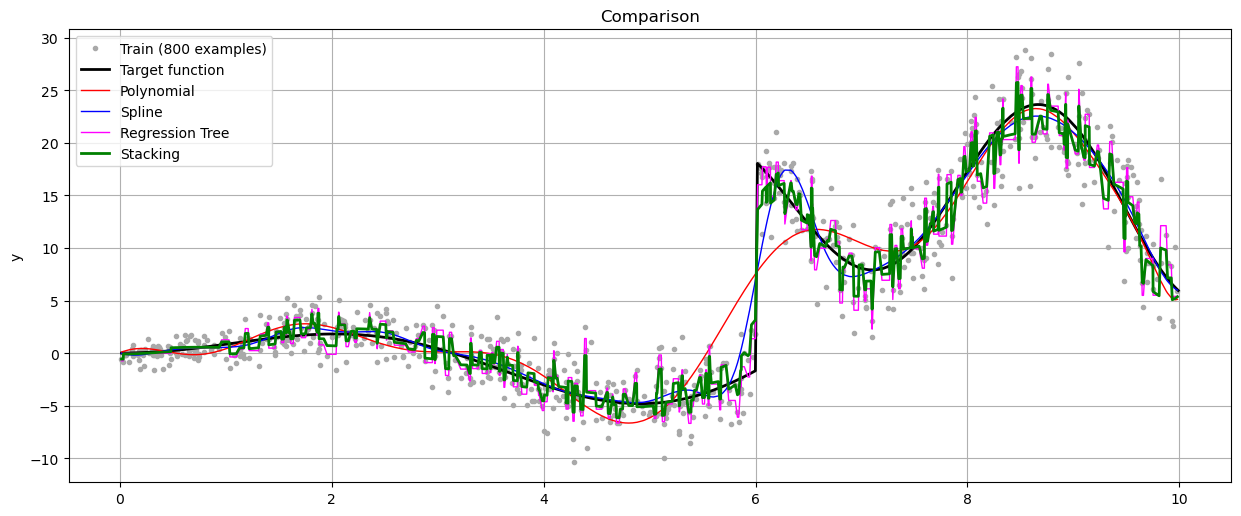

In [21]:
# Plot data
plt.figure(figsize=(15, 20))
ax1 = plt.subplot(3,1,1)
plt.plot(X_train,y_train,'.', color='darkgray', label=f'Train ({len(X_train)} examples)')
plt.plot(X, y_true, '-', color = 'black', linewidth=2, label='Target function')
plt.plot(X_train, y_train_poly, '-', color = 'red', linewidth=1, label='Polynomial')
plt.plot(X_train, y_train_spline, '-', color = 'blue', linewidth=1, label='Spline')
plt.plot(X_train, y_train_regtree, '-', color = 'magenta', linewidth=1, label='Regression Tree')
plt.plot(X_train, y_train_stack, '-', color = 'green', linewidth=2, label='Stacking')
plt.grid()
plt.legend()
plt.title('Comparison')
plt.ylabel('y')

## 1.4 Stacking generalization

In [22]:
# we use the same set of models to be stacked

stacked_genreg = StackingRegressor(
    estimators = estimators,
    #final_estimator=RandomForestRegressor(n_estimators=20, random_state=999)
    final_estimator = LinearRegression()
)

stacked_genreg = stacked_genreg.fit(X_train, y_train)
stacked_genreg

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
6930 fits failed out of a total of 62370.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6930 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\sklearn\pipeline.py", line 42

StackingRegressor(estimators=[('poly',
                               Pipeline(steps=[('polynomialfeatures',
                                                PolynomialFeatures(degree=15)),
                                               ('ridge', Ridge(alpha=0.001))])),
                              ('spline',
                               Pipeline(steps=[('splinetransformer',
                                                SplineTransformer(n_knots=25)),
                                               ('ridge', Ridge(alpha=0.001))])),
                              ('regtree',
                               Pipeline(steps=[('gridsearchcv',
                                                GridSearchCV(cv=10,
                                                             estimator=Pipeline(steps=[('DT',
                                                                                        Decisio...
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076]),
                                                                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}))]))],
                  final_estimator=LinearRegression())

In [23]:
print(stacked_genreg.final_estimator_.intercept_)
print(stacked_genreg.final_estimator_.coef_)

1.9813341642670927
[-1.03799725e-05  2.11205722e-02  8.60394516e-01]


In [24]:
# estimations using the stacked models using generalization stacking with RF
y_train_genstack = stacked_genreg.predict(X_train)
y_test_genstack = stacked_genreg.predict(X_test)

# errors
mse_tr_genstack = mean_squared_error(y_train_genstack, y_train)
mse_ts_genstack = mean_squared_error(y_test_genstack, y_test)

mae_tr_genstack = mean_absolute_error(y_train_genstack, y_train)
mae_ts_genstack = mean_absolute_error(y_test_genstack, y_test)

print(f'MSE(TR, genstack) = {mse_tr_genstack}')
print(f'MSE(TS, genstack) = {mse_ts_genstack}')
print(f'MAE(TR, genstack) = {mae_tr_genstack}')
print(f'MAE(TS, genstack) = {mae_ts_genstack}')

MSE(TR, genstack) = 5.1266577264427395
MSE(TS, genstack) = 10.357347015446717
MAE(TR, genstack) = 1.9080673754294102
MAE(TS, genstack) = 2.5489189464919035


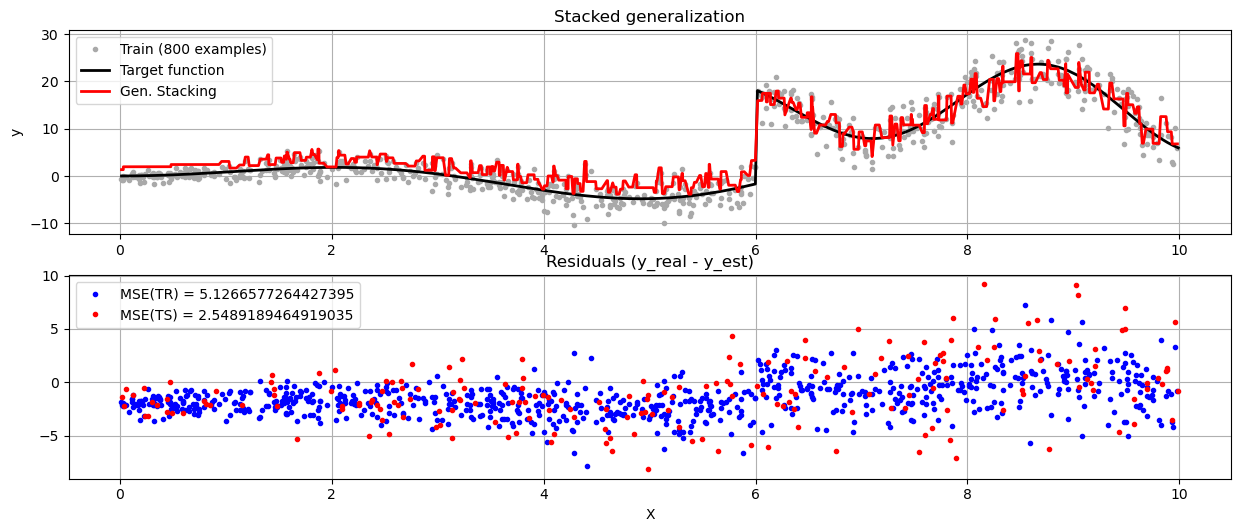

In [25]:
# Plot data
plt.figure(figsize=(15, 9))
ax1 = plt.subplot(3,1,1)
plt.plot(X_train,y_train,'.', color='darkgray', label=f'Train ({len(X_train)} examples)')
plt.plot(X, y_true, '-', color = 'black', linewidth=2, label='Target function')
plt.plot(X_train, y_train_genstack, '-', color = 'red', linewidth=2, label='Gen. Stacking')
plt.grid()
plt.legend()
plt.title('Stacked generalization')
plt.ylabel('y')

# plot residuals
plt.subplot(3,1,2, sharex = ax1)
plt.plot(X_train, y_train - y_train_genstack, '.', color = 'blue', label=f'MSE(TR) = {mse_tr_genstack}')
plt.plot(X_test, y_test - y_test_genstack, '.', color = 'red', label=f'MSE(TS) = {mae_ts_genstack}')
plt.title(f'Residuals (y_real - y_est)')
plt.legend()
plt.grid()
plt.xlabel('X')
plt.show()